<h1 style="text-align: center;">APPENDIX</h1>
<h1 style="text-align: center;">"Predicting Adult Autism with Machine Learning"</h1>

### Summary of data cleaning and modeling. 

**The dataset contained one redundant variable and two categorical variables with only one class or one extremely overrepresented class, so these three features were eliminated. Only three entries, all for age, were imputed using the median age. All other missing values were for categorical features and these were binned into an "unknown" class. Country of residence had too many sparce low single digit count classes so I binned countries with rare observations into an "Others" class. For the variable "relation", the relationship of the responder to the subject, I put missing values into an "Unknown" category and combined the categories into two other classes, Self and Others. For the variable ethnicity, sparce classes were combined into an "Others" category while South Asian and Asian were combined into the Asian category.**

**I split the cleaned dataset into a training and test set (80%/20%) before feature selection and model training. I chose SVC and XG Boost classifier as models to train and test because they were regular best performers using the package lazypredict with various train/test split ratios. I encoded all string categorical inputs using sklearn OrdinalEncoder and encoded the training and test target series using sklearn LabelEncoder. Using the mutual information measurment from sklearn feature selection on the traing set and project goals, I eliminated six features from the inputs. I optimized both models by tuning parameters using sklearn RandomizedSearch Cross Validation on the encoded training data. Both models performed well predicting the test targets but the SVC had a slight advantage with a macro f1-score of 0.95 vs. 0.93 for XG Boost. F1 was the choice for evaluation because the decision class is imbalanced in favor of a negative ASD decision.**

###  Data import and cleaning.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import xgboost as xgb
import scipy.stats as stats


# Load data into Pandas dataframe.
# Inspection of raw data file shows missing values denoted as "?"
autism_df = pd.read_csv('Autism-Adult_Data.csv', na_values="?")
# Making deep working copy.
df = autism_df.copy(deep=True)
# Transposing dataframe for readability in notebook.
transposed_df = df.transpose()
pd.set_option("display.max_rows", None, "display.max_columns", 3)
print(transposed_df)
# Displaying data types and observation counts of dataframe.
df.info()

                            0    ...             703
A1_Score                      1  ...               1
A2_Score                      1  ...               0
A3_Score                      1  ...               1
A4_Score                      1  ...               1
A5_Score                      0  ...               1
A6_Score                      0  ...               0
A7_Score                      1  ...               1
A8_Score                      1  ...               1
A9_Score                      0  ...               1
A10_Score                     0  ...               1
age                        26.0  ...            26.0
gender                        f  ...               f
ethnicity        White-European  ...  White-European
jundice                      no  ...              no
austim                       no  ...              no
contry_of_res     United States  ...          Cyprus
used_app_before              no  ...              no
result                      6.0  ...          

### Metadata per source.

Source:
Fadi Fayez Thabtah
Department of Digital Technology
Manukau Institute of Technology,
Auckland, New Zealand
fadi.fayez@manukau.ac.nz

Data Type: Nominal / categorical, binary, and continuous.

Task: Classification

Attribute Type: Categorical, continuous, and binary.

Area: Medical, health and social science

Number of Instances (records in your data set): 704

Number of Attributes (fields within each record): 21

Attribute Information:


"age" Number Age in years.

"gender" String Male or Female.

"ethnicity" String List of common ethnicities in text format.

"jundice" Born with jaundice Boolean (yes or no) Whether the case was born with jaundice.

"austim" Family member with ASD Boolean (yes or no) Whether any immediate family member has a PDD

"relation" Who is completing the test String Parent, self, caregiver, medical staff, clinician ,etc.

"contry_of_res" Country of residence String List of countries in text format.

"used_app_before" Used the screening app before Boolean (yes or no) Whether the user has used a screening app.

"age_desc" String describing age group whether user is 18 or over.

Question 1 Answer Binary (0, 1) The answer code of question 1 from AQ-10 Adult Autism Spectrum Quotient 

Question 2 Answer Binary (0, 1) The answer code of question2 

Question 3 Answer Binary (0, 1) The answer code of question3 

Question 4 Answer Binary (0, 1) The answer code of question4 

Question 5 Answer Binary (0, 1) The answer code of question5

Question 6 Answer Binary (0, 1) The answer code of question6

Question 7 Answer Binary (0, 1) The answer code of question7

Question 8 Answer Binary (0, 1) The answer code of question8

Question 9 Answer Binary (0, 1) The answer code of question9

Question 10 Answer Binary (0, 1) The answer code of question10

The AQ-10 questions are shown below.

"result" The final score obtained based on the scoring algorithm of the screening method used. This was computed in an automated manner.

"Class/ASD" Decision Class (yes/no) yes means recommended for advanced autism screening. 


The AQ-10 Adult Autism Spectrum Quotient (AQ) test is a self-administered questionnaire used to measure autistic traits in the adults. The AQ-10 is a diagnostic tool used to test an individual’s level of functioning in daily life activities. Designed by Carrie Allison, Bonnie Auyeung & Simon Baron-Cohen, this test is commonly used to diagnose autism spectrum disorder (ASD) for adults (age 16+) who do not suffer from a cognitive impairment. The items on the AQ-10 ask about an individual’s current level of functioning in various areas of daily life, including communication, social skills, and repetitive behaviours.

In [3]:
# Checking for categorical features with largely overrepresented classes.
cat_features = df.describe(include='object')
# Transposing dataframe for readability in notebook.
transposed_cat = cat_features.transpose()
pd.set_option("display.max_rows", None, "display.max_columns", 5)
print(transposed_cat)

                count unique             top freq
gender            704      2               m  367
ethnicity         609     11  White-European  233
jundice           704      2              no  635
austim            704      2              no  613
contry_of_res     704     67   United States  113
used_app_before   704      2              no  692
age_desc          704      1     18 and more  704
relation          609      5            Self  522
Class/ASD         704      2              NO  515


**The variable age_desc has only one value, "18 and more" and the variable age describes the age of the subject. This is a dataset specifically for adults, so I will drop age_desc because it is redundant.**

**used_app_before has 692 of 704 responses as "no" which is an extreme imbalance, so I will eliminate this variable.**

In [4]:
df.drop(["age_desc", "used_app_before"], axis = 1, inplace=True) # Dropping columns with no useful information.

**The variable "result" is the sum of the A1-A10 questions and is directly related to the target class which is a threshold cutoff of result. Keeping result as a predictor would allow leakage into the model so I will drop it.**

In [5]:
df.drop(["result"], axis = 1, inplace=True) # Dropping redundant column which leaks information about the target.

**The "jundice" column would be clearer by renaming it with the correctly spelled "jaundice" and the column austim is whether a family member has ASD, which would be better if named "family_with_ASD." Also, contry_of_res will be renamed country_of_res.**

In [6]:
df = df.rename(columns={'jundice':'jaundice', 'austim':'family_with_ASD', 'contry_of_res':'country_of_res'})

### Missing values, outliers, and imputation.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    int64  
 1   A2_Score         704 non-null    int64  
 2   A3_Score         704 non-null    int64  
 3   A4_Score         704 non-null    int64  
 4   A5_Score         704 non-null    int64  
 5   A6_Score         704 non-null    int64  
 6   A7_Score         704 non-null    int64  
 7   A8_Score         704 non-null    int64  
 8   A9_Score         704 non-null    int64  
 9   A10_Score        704 non-null    int64  
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        609 non-null    object 
 13  jaundice         704 non-null    object 
 14  family_with_ASD  704 non-null    object 
 15  country_of_res   704 non-null    object 
 16  relation         609 non-null    object 
 17  Class/ASD       

In [8]:
# Function to calculate and display percentage of missing values in dataframe columns.
def missing(dff):
    print("Missing values in %")
    print(round((dff.isnull().sum() * 100/ len(dff)),4).sort_values(ascending=False))
    
pd.set_option("display.max_rows", None)  # Display all features in cell.
missing(df)

Missing values in %
relation           13.4943
ethnicity          13.4943
age                 0.2841
A1_Score            0.0000
A2_Score            0.0000
country_of_res      0.0000
family_with_ASD     0.0000
jaundice            0.0000
gender              0.0000
A10_Score           0.0000
A9_Score            0.0000
A8_Score            0.0000
A7_Score            0.0000
A6_Score            0.0000
A5_Score            0.0000
A4_Score            0.0000
A3_Score            0.0000
Class/ASD           0.0000
dtype: float64


**Three variables have missing values.**

In [9]:
df.relation.unique() # Displaying classes of variable "relation."

array(['Self', 'Parent', nan, 'Health care professional', 'Relative',
       'Others'], dtype=object)

In [10]:
df.relation.value_counts() # Number of observations in each class.

relation
Self                        522
Parent                       50
Relative                     28
Others                        5
Health care professional      4
Name: count, dtype: int64

**There are many missing values for the relationship of the reporting person, relation. Although "self" is the most frequent by far, any imputation could bias the data. I will create a category "unknown" for nan values and also bin all responders other than self into an Others class.**

In [11]:
df.relation.replace(np.nan, "Unknown", inplace=True) # Creating unknown class for nans.
df.relation.replace("Health care professional", "Others", inplace=True)
df.relation.replace("Parent", "Others", inplace=True)
df.relation.replace("Relative", "Others", inplace=True)

In [12]:
df.relation.value_counts()

relation
Self       522
Unknown     95
Others      87
Name: count, dtype: int64

In [13]:
df.ethnicity.unique()

array(['White-European', 'Latino', nan, 'Others', 'Black', 'Asian',
       'Middle Eastern ', 'Pasifika', 'South Asian', 'Hispanic',
       'Turkish', 'others'], dtype=object)

In [14]:
df.ethnicity.value_counts()

ethnicity
White-European     233
Asian              123
Middle Eastern      92
Black               43
South Asian         36
Others              30
Latino              20
Hispanic            13
Pasifika            12
Turkish              6
others               1
Name: count, dtype: int64

**Again, I will create a category for nan values called unknown.**

In [15]:
df.ethnicity.replace(np.nan, "Unknown", inplace=True)

**There are two categories for Others, "Others" and "others." I will combine both into "Others." I will also bin grossly underrepresented ethnicities into an Others class.**

In [16]:
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Others' if x == 'Turkish' else x)
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Others' if x == 'Hispanic' else x)
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Others' if x == 'Pasifika' else x)
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Others' if x == 'others' else x)
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Others' if x == 'Latino' else x)
df['ethnicity'] = df['ethnicity'].apply(lambda x: 'Asian' if x == 'South Asian' else x)

In [17]:
df.ethnicity.value_counts()

ethnicity
White-European     233
Asian              159
Unknown             95
Middle Eastern      92
Others              82
Black               43
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Brazil'),
  Text(2, 0, 'Spain'),
  Text(3, 0, 'Egypt'),
  Text(4, 0, 'New Zealand'),
  Text(5, 0, 'Bahamas'),
  Text(6, 0, 'Burundi'),
  Text(7, 0, 'Austria'),
  Text(8, 0, 'Argentina'),
  Text(9, 0, 'Jordan'),
  Text(10, 0, 'Ireland'),
  Text(11, 0, 'United Arab Emirates'),
  Text(12, 0, 'Afghanistan'),
  Text(13, 0, 'Lebanon'),
  Text(14, 0, 'United Kingdom'),
  Text(15, 0, 'South Africa'),
  Text(16, 0, 'Italy'),
  Text(17, 0, 'Pakistan'),
  Text(18, 0, 'Bangladesh'),
  Text(19, 0, 'Chile'),
  Text(20, 0, 'France'),
  Text(21, 0, 'China'),
  Text(22, 0, 'Australia'),
  Text(23, 0, 'Canada'),
  Text(24, 0, 'Saudi Arabia'),
  Text(25, 0, 'Nethe

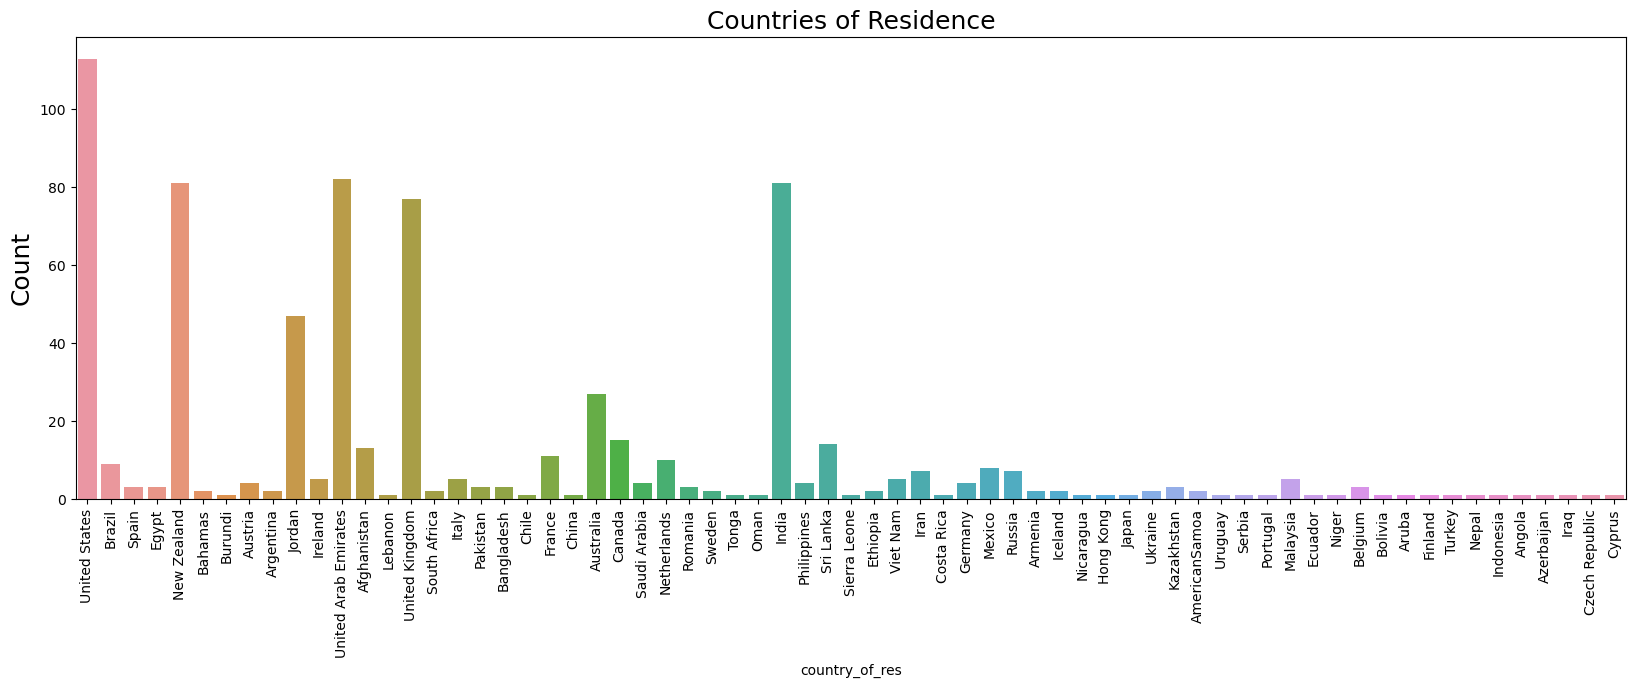

In [18]:
plt.figure(figsize=(20,6))
sns.countplot(x="country_of_res", data=df)
plt.title("Countries of Residence", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=90)

**There are too many categories for country of residence for the training/test split and modeling. I will filter the top 10 and bin the others into "Others."**

In [19]:
df_country_of_res = pd.DataFrame(df['country_of_res'].value_counts())
countries = list(df_country_of_res[df_country_of_res.values < 16].index)
df['country_of_res'] = df['country_of_res'].apply(lambda x: 'Others' if x in countries else x)

df['country_of_res'].value_counts()

country_of_res
Others                  196
United States           113
United Arab Emirates     82
New Zealand              81
India                    81
United Kingdom           77
Jordan                   47
Australia                27
Name: count, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Others'),
  Text(2, 0, 'New Zealand'),
  Text(3, 0, 'Jordan'),
  Text(4, 0, 'United Arab Emirates'),
  Text(5, 0, 'United Kingdom'),
  Text(6, 0, 'Australia'),
  Text(7, 0, 'India')])

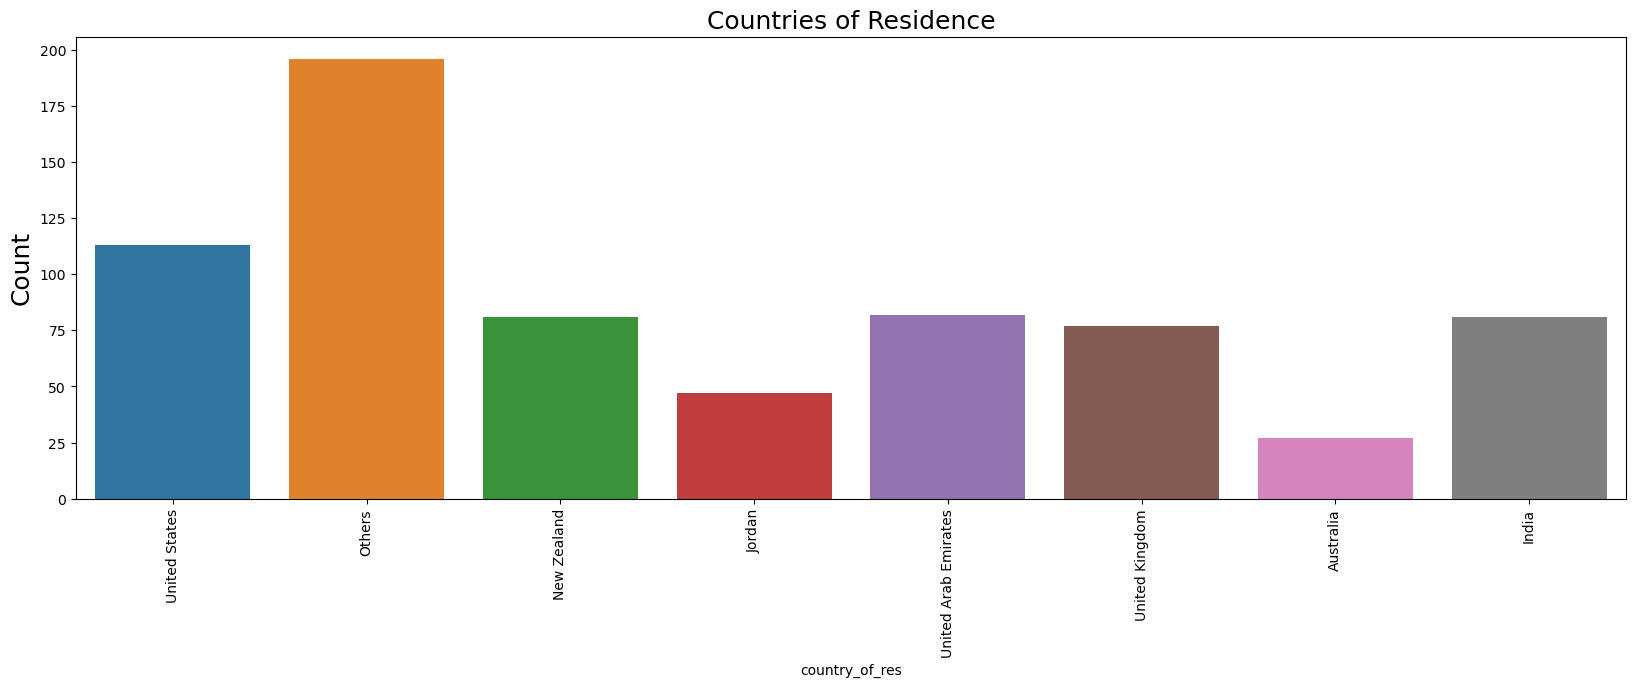

In [20]:
plt.figure(figsize=(20,6))
sns.countplot(x="country_of_res", data=df)
plt.title("Countries of Residence", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=90)

**Age variable cleaning.**

In [21]:
# Descriptive statistics for age.
df.age.describe()

count    702.000000
mean      29.698006
std       16.507465
min       17.000000
25%       21.000000
50%       27.000000
75%       35.000000
max      383.000000
Name: age, dtype: float64

**There are two missing values for age and one entry of 383 years old which has to be a mistake. I will use the median age to impute all three observations.**

In [22]:
df.age.replace(df.age.max(), df.age.median(), inplace=True)
df.age.replace(np.nan, df.age.median(), inplace=True)
df.age.describe()

count    704.000000
mean      29.184659
std        9.691837
min       17.000000
25%       21.000000
50%       27.000000
75%       35.000000
max       64.000000
Name: age, dtype: float64

### Modeling.

In [89]:
# Splitting the data into a traing and test set.
X = df.drop(['Class/ASD'], axis=1)
y = df['Class/ASD']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80, random_state=9)
X_train.head()

,A1_Score,A2_Score,...,country_of_res,relation
448,1,1,...,United States,Self
703,1,0,...,Others,Self
505,1,0,...,United Kingdom,Unknown
491,0,0,...,Others,Self
279,0,1,...,Others,Self


**Encoding categorical features for machine learning.**

In [90]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn import set_config

set_config(transform_output="pandas")  # Returns a dataframe vs. matrix.
# Separating the nominal features.
num_features = X_train.select_dtypes(exclude=['object']).columns.values.tolist()
X_train_cat = X_train.drop(num_features, axis=1)
X_test_cat = X_test.drop(num_features, axis=1)
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

oe = OrdinalEncoder()
oe.fit(X_train_cat)  # Using OrdinalEncoder with no ranking sequence.

X_train_cat_enc = oe.transform(X_train_cat)
X_test_cat_enc = oe.transform(X_test_cat)
X_train_cat_enc.head()

X_train_enc = pd.concat([X_train_cat_enc, X_train_num], axis=1)
X_test_enc = pd.concat([X_test_cat_enc, X_test_num], axis=1) 
                        
le = LabelEncoder()
le.fit(y_train)  # Encoding decision classes as 0,1.
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [91]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 448 to 382
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           563 non-null    float64
 1   ethnicity        563 non-null    float64
 2   jaundice         563 non-null    float64
 3   family_with_ASD  563 non-null    float64
 4   country_of_res   563 non-null    float64
 5   relation         563 non-null    float64
 6   A1_Score         563 non-null    int64  
 7   A2_Score         563 non-null    int64  
 8   A3_Score         563 non-null    int64  
 9   A4_Score         563 non-null    int64  
 10  A5_Score         563 non-null    int64  
 11  A6_Score         563 non-null    int64  
 12  A7_Score         563 non-null    int64  
 13  A8_Score         563 non-null    int64  
 14  A9_Score         563 non-null    int64  
 15  A10_Score        563 non-null    int64  
 16  age              563 non-null    float64
dtypes: float64(7), int6

#### Feature selection.

<Axes: >

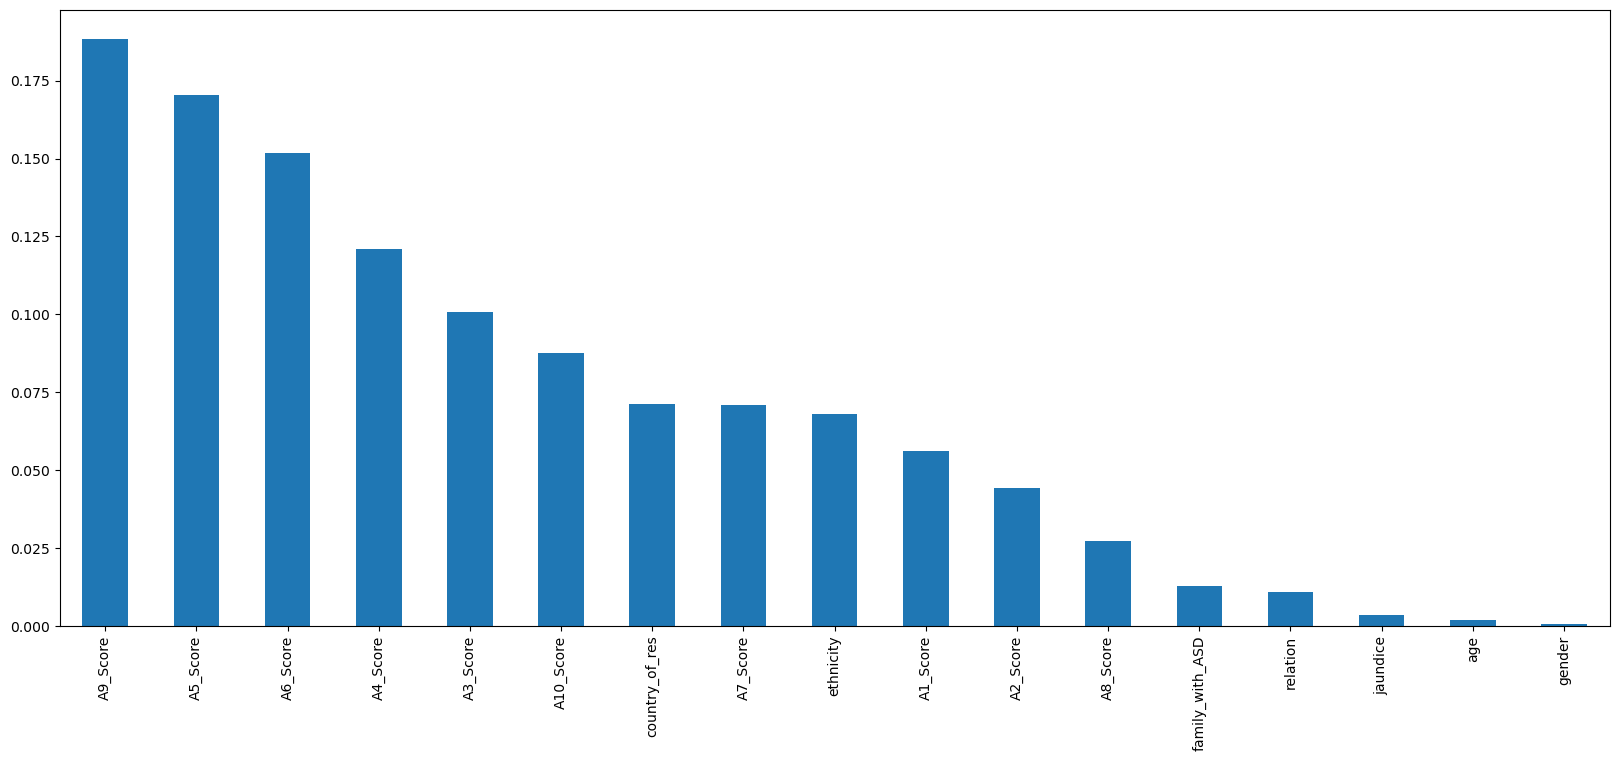

In [92]:
from sklearn.feature_selection import mutual_info_classif

# Determining the relationship strength between inputs and target.
mutual_info = mutual_info_classif(X_train_enc, y_train_enc, discrete_features=[range(16)])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_enc.columns 
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [79]:
# Dropping features with low mutual info and A5_Score because of question ambiguity.
# Keeping age because EDA showed a difference of means.
X_train_enc2 = X_train_enc.drop(['A8_Score', 'gender', 'jaundice', 'A7_Score', 'A10_Score',                                 
                                 'A5_Score'], axis=1)
X_test_enc2 = X_test_enc.drop(['A8_Score', 'gender', 'jaundice', 'A7_Score', 'A10_Score',
                               'A5_Score'], axis=1)

In [80]:
X_train_enc2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 448 to 382
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ethnicity        563 non-null    float64
 1   family_with_ASD  563 non-null    float64
 2   country_of_res   563 non-null    float64
 3   relation         563 non-null    float64
 4   A1_Score         563 non-null    int64  
 5   A2_Score         563 non-null    int64  
 6   A3_Score         563 non-null    int64  
 7   A4_Score         563 non-null    int64  
 8   A6_Score         563 non-null    int64  
 9   A9_Score         563 non-null    int64  
 10  age              563 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 52.8 KB


In [81]:
# Calculating pairwise mutual information scores for all inputs with the target.
mutual_info = mutual_info_classif(X_train_enc2, y_train_enc, discrete_features=[range(10)])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_enc2.columns 
mutual_info.sort_values(ascending=False)

A9_Score          0.19
A6_Score          0.15
A4_Score          0.12
A3_Score          0.10
country_of_res    0.07
ethnicity         0.07
A1_Score          0.06
A2_Score          0.04
family_with_ASD   0.01
relation          0.01
age               0.01
dtype: float64

### Optimizing models and predictions on test data.

In [83]:
# Specify parameters and distributions to sample from.
param_dist = {
  'C': stats.uniform(0.1, 1e4),
  'gamma': stats.loguniform(1e-6, 1e+1)
}
n_iter_search = 30
random_search = RandomizedSearchCV(
    SVC(), 
    param_distributions=param_dist,
    n_iter=n_iter_search, 
    refit=True,
    verbose=1,
    scoring='f1'
)
# Optimizing model with training set.
random_search.fit(X_train_enc2, y_train_enc)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=SVC(), n_iter=30,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DD5579BE90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DD5564AB90>},
                   scoring='f1', verbose=1)

In [84]:
random_search.best_params_

{'C': 5841.9902992699035, 'gamma': 0.0006737447787736779}

In [85]:
random_search.best_estimator_

SVC(C=5841.9902992699035, gamma=0.0006737447787736779)

In [86]:
# Predicting target values for hold-out data.
random_predictions = random_search.predict(X_test_enc2)
print(confusion_matrix(y_test_enc, random_predictions))

[[103   1]
 [  4  33]]


In [87]:
print(classification_report(y_test_enc, random_predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       104
           1       0.97      0.89      0.93        37

    accuracy                           0.96       141
   macro avg       0.97      0.94      0.95       141
weighted avg       0.96      0.96      0.96       141



In [95]:
# Define the hyperparameter distributions.
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object.
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object.
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1')

# Fit the RandomizedSearchCV object to the training data.
random_search.fit(X_train_enc2, y_train_enc)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D04167090>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D07187090>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D0727BC90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022D03452350>},
                   scoring='f1')

In [89]:
random_search.best_params_

{'learning_rate': 0.08923627784239767,
 'max_depth': 3,
 'n_estimators': 78,
 'subsample': 0.9729260136603006}

In [90]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08923627784239767,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=78, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [91]:
# Predicting target values for hold-out data.
random_predictions = random_search.predict(X_test_enc2)
print(confusion_matrix(y_test_enc, random_predictions))

[[102   2]
 [  5  32]]


In [92]:
print(classification_report(y_test_enc, random_predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       104
           1       0.94      0.86      0.90        37

    accuracy                           0.95       141
   macro avg       0.95      0.92      0.93       141
weighted avg       0.95      0.95      0.95       141



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

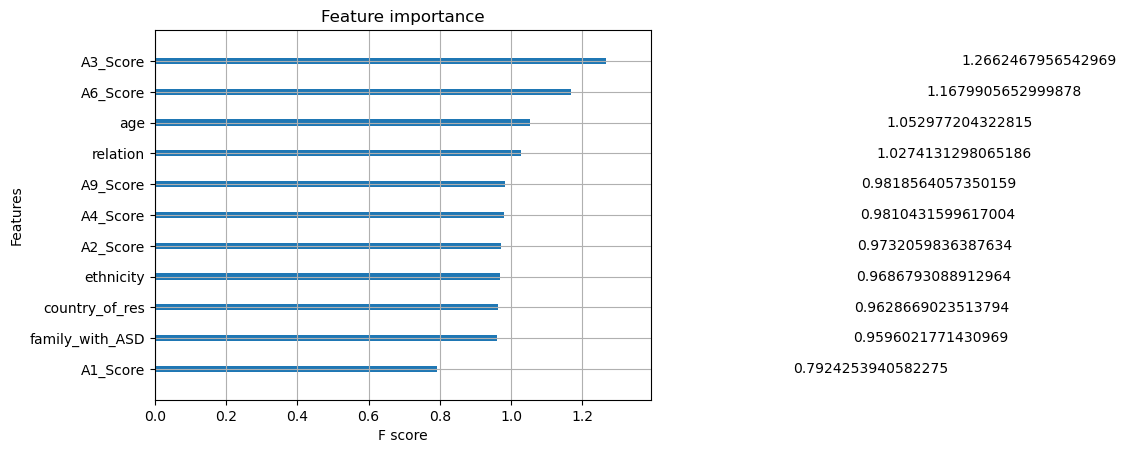

In [97]:
# Plotting feature importance for xgboost model.
from xgboost import plot_importance
plot_importance(random_search.best_estimator_, importance_type='gain')